# Example - Marketing to frequent fliers

### Introduction

The file `fliers.csv` contains information on 3,999 passengers who belong to the EastWest's **frequent flier program**. For each passenger, the data include information on their mileage history and on different ways they accrued or spent miles in the last year. 

In this example, the goal is to identify **clusters of passengers** that have similar characteristics for the purpose of targeting different segments for different types of mileage offers. Key issues are their flying patterns, earning and use of frequent flier rewards, and use of the airline credit card.

### The data set

The variables included in the data set are:

* `id`, a unique customer ID.

* `balance`, the number of miles eligible for award travel.

* `qual_miles`, the number of miles counted as qualifying for Topflight status.

* `cc1_miles`, the number of miles earned with frequent flier credit card in the past 12 months, coded as 1 (under 5,000), 2 (5,000-10,000), 3 (10,001-25,000), 4 (25,001-50,000).

* `cc2_miles`, the number of miles earned with Rewards credit card in the past 12 months, coded as above.

* `cc3_miles`, the number of miles earned with Small Business credit card in the past 12 months, coded as above.

* `bonus_miles`, the number of miles earned from non-flight bonus transactions in the past 12 months.

* `bonus_trans`, the number of non-flight bonus transactions in the past 12 months.

* `flight_miles_12mo`, the number of miles flight miles in the past 12 months.

* `flight_trans_12mo`, the number of flight transactions in the past 12 months.

* `days_since_enroll`, the number of days since the customer was enrolled.

* `award`, a dummy for having an award.

Source: G Shmueli and PC Bruce (2016), based upon a real business case and real data. The company name has been changed.

### Importing the data

We import the data from the seven files with NumPy's `recfromcsv` as usual.

In [1]:
import numpy as np

In [2]:
data = np.recfromcsv('fliers.csv')

In [7]:
data.shape

(3999,)

In [6]:
data[:10]

rec.array([( 1,  28143, 0, 1, 1, 1,   174,  1,    0,  0, 7000, 0),
           ( 2,  19244, 0, 1, 1, 1,   215,  2,    0,  0, 6968, 0),
           ( 3,  41354, 0, 1, 1, 1,  4123,  4,    0,  0, 7034, 0),
           ( 4,  14776, 0, 1, 1, 1,   500,  1,    0,  0, 6952, 0),
           ( 5,  97752, 0, 4, 1, 1, 43300, 26, 2077,  4, 6935, 1),
           ( 6,  16420, 0, 1, 1, 1,     0,  0,    0,  0, 6942, 0),
           ( 7,  84914, 0, 3, 1, 1, 27482, 25,    0,  0, 6994, 0),
           ( 8,  20856, 0, 1, 1, 1,  5250,  4,  250,  1, 6938, 1),
           ( 9, 443003, 0, 3, 2, 1,  1753, 43, 3850, 12, 6948, 1),
           (10, 104860, 0, 3, 1, 1, 28426, 28, 1150,  3, 6931, 1)],
          dtype=[('id', '<i8'), ('balance', '<i8'), ('qual_miles', '<i8'), ('cc1_miles', '<i8'), ('cc2_miles', '<i8'), ('cc3_miles', '<i8'), ('bonus_miles', '<i8'), ('bonus_trans', '<i8'), ('flight_miles_12mo', '<i8'), ('flight_trans_12mo', '<i8'), ('days_since_enroll', '<i8'), ('award', '<i8')])

### Exploratory analysis

At first glance, the data show a mix of scales, suggesting that some of the clustering features can have a much stronger influence on the clusters than others. This first impression can be easily confirmed by a quick explorattion of the data. For instance, the number of miles eiligible for award travel has the highest values and a skewed distribution:

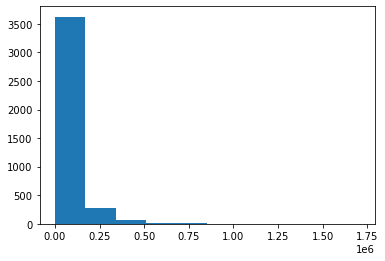

In [8]:
from matplotlib import pyplot as plt
plt.hist(data['balance']);

The distribution is also skewed, though with lower values, for the qualified and the bonus miles: 

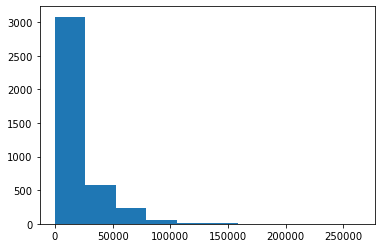

In [13]:
plt.hist(data['bonus_miles']);

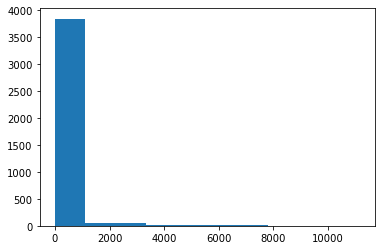

In [9]:
plt.hist(data['qual_miles']);

The days since enrollment show a more symmetric distribution:

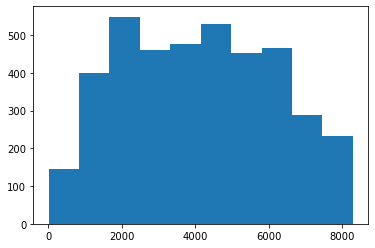

In [15]:
plt.hist(data['days_since_enroll']);

The distributions of the features related to the credit cards are, in two cases, very unbalanced.

In [10]:
np.unique(data['cc1_miles'], return_counts=True)

(array([1, 2, 3, 4, 5]), array([2289,  284,  613,  525,  288]))

In [11]:
np.unique(data['cc2_miles'], return_counts=True)

(array([1, 2, 3]), array([3956,   28,   15]))

In [12]:
np.unique(data['cc3_miles'], return_counts=True)

(array([1, 2, 3, 4, 5]), array([3981,    3,    4,    6,    5]))

### Unstructuring the data

In spite of all these problems, data of this type are frequently used in customer segmentation. So, let us see how they work. We create a features matrix by unstructuring the recarray `data`, leaving aside the column `id`:

In [35]:
from numpy.lib.recfunctions import structured_to_unstructured
X = structured_to_unstructured(data)[:, 1:]

### 4-cluster analysis, first round

We import the estimator class `KMeans`:

In [36]:
from sklearn.cluster import KMeans

We instantiate an estimator, which we call `clus`, setting the number of clusters at 4 and `random_state=0`for repeatability:

In [63]:
clus = KMeans(n_clusters=4, random_state=0)

We fit the estimator to the features matrix `X`. Note that, in unsupervised learning, it is `mod.fit(X)`, instead of `mod.fit(X, y)`.

In [64]:
clus.fit(X)

KMeans(n_clusters=4, random_state=0)

As a result of fitting `clus`, we can extract two interesting attributes, `labels_` and `cluster_centers_`:

In [65]:
labels = clus.labels_
centers = clus.cluster_centers_

With 4 clusters, the labels are 0, 1, 2 and 3. They come as a 1d array in which every term indicates the cluster to which the corresponding customer has been assigned. In customer segmentation, you should always check that all the segments have a minimum size, compared to the number of customers, which is here 3,999. Unfortunately, this is not the case for these segments:

In [40]:
np.unique(labels4, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([2810,  185,  978,   26]))

The centers are four 11-dimensional points, one for every segment. The coordinates of a center are the average values of the 11 features for the corresponding segment. They come as a 2d array, with one center in each row:

In [66]:
centers.shape

(4, 11)

To examine on the screen the centers having them as a (4,11)-array is a bit challenging for our eyes, so we are going to take advantage of the package Pandas to display them as a friendly table. We add column names and a last column with the cluster size.

In [67]:
import pandas as pd
pdcenters = pd.DataFrame(centers).round(1)
pdcenters.columns = data.dtype.names[1:]
pdcenters['size'] = np.unique(labels, return_counts=True)[1]
pdcenters

,balance,qual_miles,cc1_miles,cc2_miles,cc3_miles,bonus_miles,bonus_trans,flight_miles_12mo,flight_trans_12mo,days_since_enroll,award,size
0,31039.4,101.6,1.7,1.0,1.0,10127.8,9.3,290.4,0.9,3785.4,0.3,2810
1,323009.8,337.2,3.1,1.0,1.0,43644.1,18.6,1283.3,3.9,5532.6,0.6,185
2,128475.2,220.3,2.9,1.0,1.0,31256.2,16.5,755.9,2.2,4748.0,0.4,978
3,842320.2,512.7,3.3,1.0,1.1,57797.2,22.7,1845.9,7.0,6463.0,0.8,26


It is plainly seen that the segments only reflect who flies more. This is not unexpected, given the features that we are using in the analysis.

### Normalization

In [58]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
scaler = MinMaxScaler()

In [60]:
scaler.fit(X)

MinMaxScaler()

In [61]:
Z = scaler.transform(X)

### 4-cluster analysis, second round

We redo the analysis, using now the normalized features matrix `Z`.

In [68]:
clus.fit(Z)
labels = clus.labels_
centers = clus.cluster_centers_
pdcenters = pd.DataFrame(centers)
pdcenters.columns = data.dtype.names[1:]
pdcenters['size'] = np.unique(labels, return_counts=True)[1]
pdcenters

,balance,qual_miles,cc1_miles,cc2_miles,cc3_miles,bonus_miles,bonus_trans,flight_miles_12mo,flight_trans_12mo,days_since_enroll,award,size
0,0.023901,0.008284,0.023195,0.008962,0.001054,0.012648,0.075450,0.007353,0.012433,0.436112,3.275158e-15,1897
1,0.048995,0.026054,0.039004,0.016345,0.002229,0.033564,0.121825,0.033427,0.059407,0.522892,1.000000e+00,673
2,0.063535,0.017791,0.728960,0.000619,0.006498,0.172970,0.234904,0.023160,0.040421,0.586139,1.000000e+00,808
3,0.069234,0.006558,0.644122,0.000805,0.005636,0.118637,0.200595,0.007313,0.011941,0.534640,-3.885781e-16,621


### Homework

Use `random_state=1` and `random_state=2` and compare.